In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import time
from IPython import display 

from pyDPMP.messagepassing import MaxSumMP
from pyDPMP.mrf import MRF
from pyDPMP.particleselection import SelectDiverse
from pyDPMP.proposals import random_walk_proposal_1d
from pyDPMP.util import set_seed
from pyDPMP import DPMP_infer

In this example, we'll run D-PMP on a 2-D Gaussian. While we would generally not represent a 2-D Gaussian as a pairwise MRF, it provides a nice way to get up to speed with the D-PMP. Consider,

$$ \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \sim \mathcal{N}(\mu, \Sigma).$$

Here, we'll set

$$
\begin{align}
\mu &= \mathbf{0} \\
\Sigma &= \begin{bmatrix} 1 & 0 \\ 1 & 3 \end{bmatrix}
\end{align}
$$

In [2]:
# The mean vector and covariance matrix
mu = np.array([0.0, 0.0])
cov = np.array([[1, 0], [1, 3]])

<matplotlib.contour.QuadContourSet instance at 0x1173b2128>

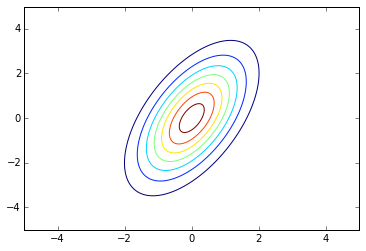

In [3]:
dist = multivariate_normal(mean=mu, cov=cov)

x = np.arange(-5, 5, 0.01)
y = np.arange(-5, 5, 0.01)
x_mesh, y_mesh = np.meshgrid(x, y)
mesh = np.concatenate([x_mesh[..., np.newaxis], y_mesh[..., np.newaxis]], axis=2)

plt.contour(x_mesh, y_mesh, dist.pdf(mesh))

We can cast the distribution over $x_1$ and $x_2$ as an MRF with one node for each variable and a single pairwise potential between the two. In this case, we see that

$$
\begin{align}
\log p(x_1,x_2) + C &= -\frac{1}{2} (\mathbf{x} - \mu)^T \Sigma^{-1} (\mathbf{x} - \mu) \\
    &= -\frac{1}{2} \begin{bmatrix} x_1 - \mu_1 & x_2 - \mu_2 \end{bmatrix} \begin{bmatrix} p_{11} & p_{12} \\ p_{21} & p_{22} \end{bmatrix} \begin{bmatrix} x_1 - \mu_1 \\ x_2 - \mu_2 \end{bmatrix} \\
    &= -\frac{1}{2} \left( p_{11} (x_1 - \mu_1)^2 + (p_{12} + p_{21})(x_1 - \mu_1)(x_2 - \mu_2) + p_{22} (x_2 - \mu_2)^2 \right)
\end{align}
$$

where

$$P = \Sigma^{-1} = \begin{bmatrix} p_{11} & p_{12} \\ p_{21} & p_{22} \end{bmatrix}$$

is the precision matrix. So, our log potentials are

$$
\begin{align}
\psi_1(x_1) &= -\frac{1}{2} p_{11} (x_1 - \mu_1)^2 \\
\psi_2(x_2) &= -\frac{1}{2} p_{22} (x_2 - \mu_2)^2 \\
\psi_{12}(x_1, x_2) &= -\frac{1}{2} (p_{12} + p_{21})(x_1 - \mu_1)(x_2 - \mu_2)
\end{align}
$$

We can construct such an MRF as follows.

In [4]:
P = np.linalg.inv(cov)

nodes = [0, 1]
edges = [(0, 1)]
node_pot = lambda s, x_s: -0.5 * P[s, s] * (x_s - mu[s]) ** 2
edge_pot = lambda s, t, x_s, x_t: -0.5 * (x_s - mu[s]) * (x_t - mu[t]) * (P[s,t] + P[t,s])

mrf = MRF(nodes, edges, node_pot, edge_pot)

The D-PMP algorithm requires 5 elements:

* a pairwise, continuous MRF
* a particle proposal
* an initial set of particles
* a discrete max-product algorithm (Max-Sum, Tree-reweighted belief propogation, etc.)
* a particle selection algorithm (either the diversity objective from the ICML 2014 paper or the LazyGreedy objective from the ICML 2015 paper)

Well, having the MRF is a bit of a given. For the discrete max-product algorithm, we can just use Max-Sum for tree-structured MRFs and TRWBP for loopy models. And in our experience, the particle selection objective does not have a large impact on performance.

This leaves us with two problem-specific parameters: the proposal and the initial particle set. In this example, we'll use a 1-D random walk proposal with standard deviation 1. This means that at every iteration we'll perturb the current particles at each node with Gaussian noise. It's a fairly naïve proposal but it'll get the job done here.

In [5]:
proposal = random_walk_proposal_1d(1)

For the initial particle set, we'll put one particle at 1.0 for both $x_1$ and $x_2$.

In [6]:
x0 = {0: [1.0], 1: [1.0]}

We'll the number of particles at each node to be 2.

In [7]:
nParticles = 2

Now, we're ready to run D-PMP! We've left most of the settings to their defaults with some exceptions:

* `conv_tol` is set to None to disable convergence checking.
* `max_iters` is set to 10.
* We've added a nice callback that plots the particles at each iteration, with the MAP estimate in red. We've also added a 0.5 second delay so that you can see the animation play smoothly. Callbacks are a great way to see what's going on inside D-PMP's brain.

It's worth noting that one important option we did not set here is the number of augmented particles, `nAugmented`. At each iteration, D-PMP will propose as many particles as necessary in order to reach `nAugmented` particles at each node before performing particle selection. By default, `nAugmented` will be twice `nParticles`.

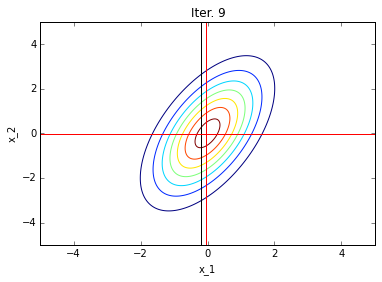

In [8]:
set_seed(0)

def callback(info):
    x = info['x']
    xMAP = info['xMAP']
    
    plt.clf()
    plt.contour(x_mesh, y_mesh, dist.pdf(mesh))
    plt.vlines(x[0], -5, 5)
    plt.hlines(x[1], -5, 5)
    plt.vlines(xMAP[0], -5, 5, 'r')
    plt.hlines(xMAP[1], -5, 5, 'r')
    
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.title('Iter. %d' % info['iter'])
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)

xMAP, xParticles, stats = DPMP_infer(mrf,
                                     x0,
                                     nParticles,
                                     proposal,
                                     SelectDiverse(),
                                     MaxSumMP(mrf),
                                     conv_tol=None,
                                     max_iters=10,
                                     callback=callback)

display.clear_output(wait=True)

Finally, we check that our estimate of the MAP is accurate:

In [9]:
xMAP

{0: -0.05292197516849475, 1: -0.030930369910096456}